# Tutorial: 3D spatial domain identification

We extended RGAST for 3D spatial domain identification by simultaneously considering the relationships within each section and neighboring spots between adjacent section. The underlying principle behind the use of 3D spatial neighborhoods lies in the assumption that biological differences between consecutive sections should demonstrate continuity, so we can enhance the similarity between adjacent sections to eliminate the discontinuous independent technical noises.

In this tutorial, we applied RGAST onto a pseudo 3D ST data constructed by aligning six mouse hypothalamic preoptic sections profiled by MERFISH.

Data used in this study can be download in https://drive.google.com/drive/folders/1EfefAWEy6XTL12tCsfuh9rcnnKEVrNLW?usp=drive_link, you are supposed to move the MERFISH/ folder into the data/ directory.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import RGAST

In [3]:
dir_input = '../data/MERFISH/'
dir_output = '../output/3D'

## Read the aligned & perpeocessed data

In [4]:
adata = sc.read_h5ad(f'../data/MERFISH/merge_3D.h5ad')
section_colors = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326']

## Visulization

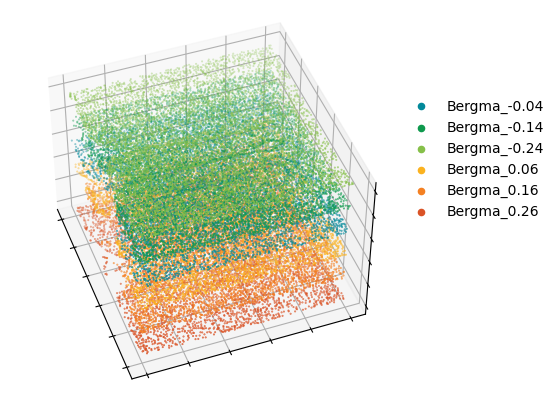

In [8]:
fig = plt.figure(figsize=(5, 5))
ax1 = plt.axes(projection='3d')
for it, label in enumerate(np.unique(adata.obs['Section_id'])):
    temp_Coor = adata.obs.loc[adata.obs['Section_id']==label, :]
    temp_xd = temp_Coor['Centroid_X']
    temp_yd = temp_Coor['Centroid_Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=section_colors[it],s=0.2, marker="o", label=label)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

plt.legend(bbox_to_anchor=(1,0.8), markerscale=10, frameon=False)

ax1.elev = 45
ax1.azim = -20

plt.savefig(f'{dir_output}/align.pdf', bbox_inches='tight')

## Constructing 3D spatial neighborhood & expression similarity relationships

In [7]:
section_order = ['Bergma_0.26', 'Bergma_0.16', 'Bergma_0.06',
                 'Bergma_-0.04', 'Bergma_-0.14', 'Bergma_-0.24']

In [8]:
RGAST.utils.Cal_Spatial_Net_3D(adata, rad_cutoff_2D=50, rad_cutoff_Zaxis=50,
                           key_section='Section_id', section_order = section_order, verbose=True)

Radius used for 2D SNN: 50
Radius used for SNN between sections: 50
------Calculating 2D SNN of section  Bergma_-0.04
This graph contains 32928 edges, 5488 cells.
6.0000 neighbors per cell on average.
------Calculating 2D SNN of section  Bergma_-0.14
This graph contains 35556 edges, 5926 cells.
6.0000 neighbors per cell on average.
------Calculating 2D SNN of section  Bergma_-0.24
This graph contains 33258 edges, 5543 cells.
6.0000 neighbors per cell on average.
------Calculating 2D SNN of section  Bergma_0.06
This graph contains 32058 edges, 5343 cells.
6.0000 neighbors per cell on average.
------Calculating 2D SNN of section  Bergma_0.16
This graph contains 31014 edges, 5169 cells.
6.0000 neighbors per cell on average.
------Calculating 2D SNN of section  Bergma_0.26
This graph contains 28992 edges, 4832 cells.
6.0000 neighbors per cell on average.
------Calculating SNN between adjacent section Bergma_0.26 and Bergma_0.16.
This graph contains 29843 edges, 10001 cells.
2.9840 neighbor

In [9]:
RGAST.utils.Cal_Expression_3D(adata, k_cutoff=6, key_section='Section_id', verbose=True)

------Calculating Expression Network of section  Bergma_-0.04
------Calculating Expression Network of section  Bergma_-0.14
------Calculating Expression Network of section  Bergma_-0.24
------Calculating Expression Network of section  Bergma_0.06
------Calculating Expression Network of section  Bergma_0.16
------Calculating Expression Network of section  Bergma_0.26


## Running 3D RGAST

In [10]:
train_RGAST = RGAST.Train_RGAST(adata,dim_reduction='PCA',device_idx=0)

Size of Input:  (32301, 100)


In [11]:
train_RGAST.train_RGAST(hidden_dims=[64, 16], early_stopping=False, save_path=dir_output,n_epochs=500)

 20%|██        | 100/500 [10:41<39:58,  6.00s/it]

## Clustering

In [15]:
from RGAST.utils import res_search_fixed_clus
sc.pp.neighbors(adata, use_rep='RGAST')
sc.tl.umap(adata)
_ = res_search_fixed_clus(adata, 9)

### UMAP visulization

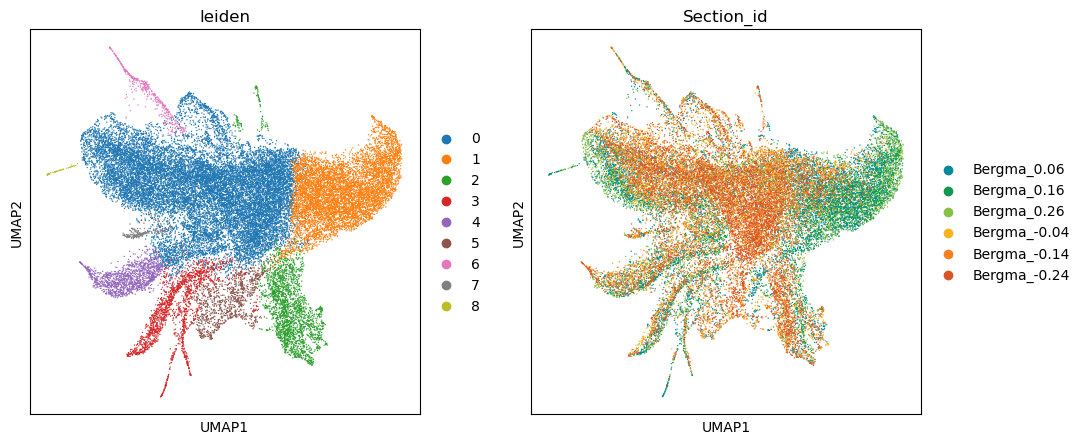

In [15]:
plt.rcParams["figure.figsize"] = (5, 5)
adata.uns['Section_id_colors'] = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326']
sc.pl.umap(adata, color=['leiden', 'Section_id'])

### Visulization of each 3D domain

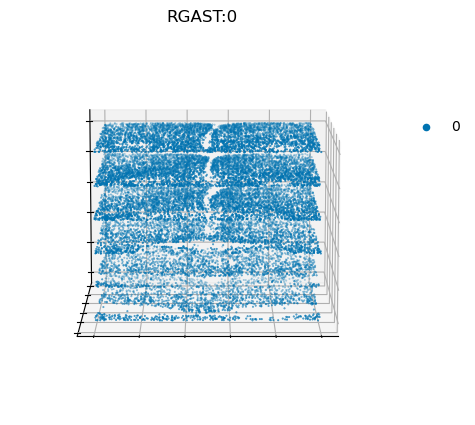

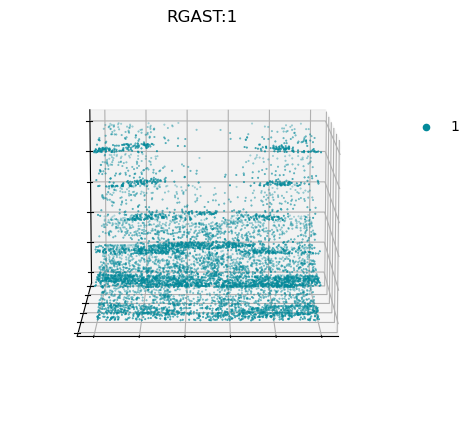

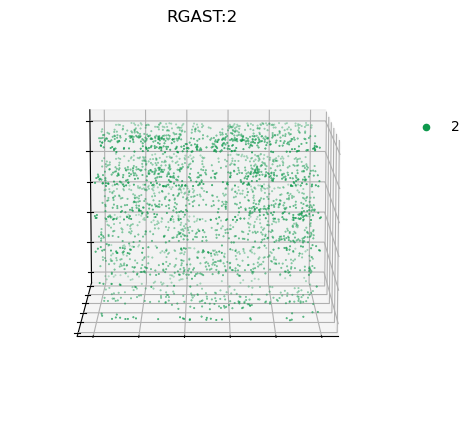

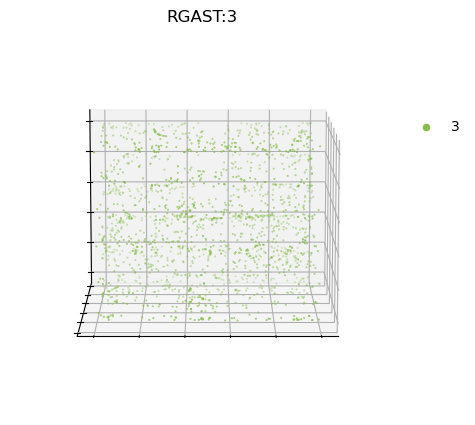

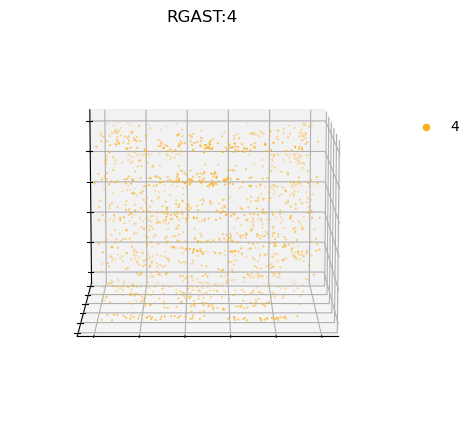

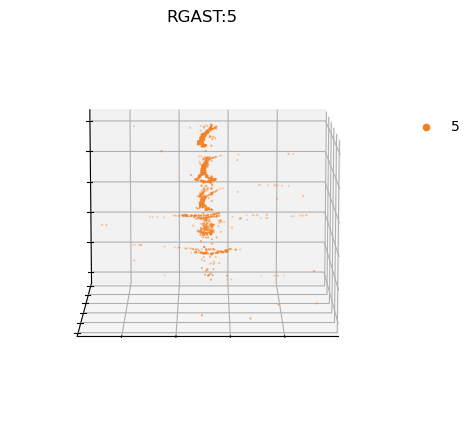

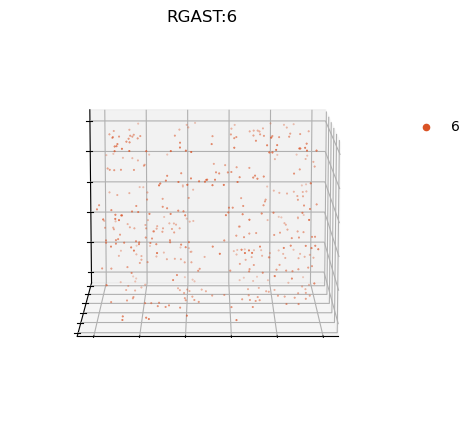

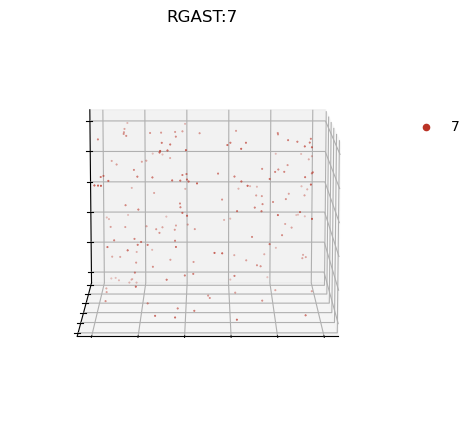

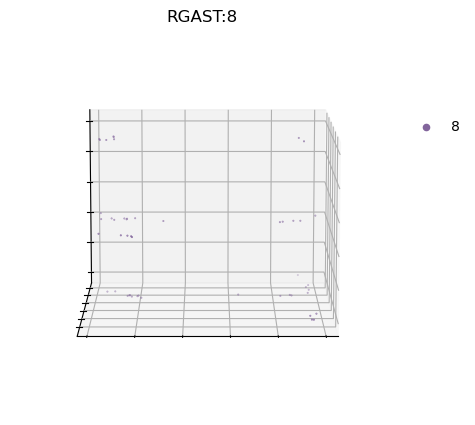

In [61]:
adata.uns['Section_id_colors'] = ['#0073B1', '#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326', '#82659C']
for it, label in enumerate(np.unique(adata.obs['leiden'])):
    fig = plt.figure(figsize=(5, 5))
    ax1 = plt.axes(projection='3d')

    temp_Coor = adata.obs.loc[adata.obs['leiden']==label, :]
    temp_xd = temp_Coor['Centroid_X']
    temp_yd = temp_Coor['Centroid_Y']
    temp_zd = temp_Coor['Z']
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=adata.uns['Section_id_colors'][it],s=0.2, marker="o", label=label)

    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_zlabel('')

    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])

    plt.legend(bbox_to_anchor=(1.2,0.8), markerscale=10, frameon=False)
    plt.title(f'RGAST:{label}')

    ax1.elev = 10
    ax1.azim = 90

    # plt.show()
    plt.savefig(f'{dir_output}/3D_9/e10a90/{label}.pdf', bbox_inches='tight')